In [2]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, NLocal, PauliTwoDesign
# from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD # chemistry simulation ansatzes, for example the UCCSD ansatz prepares a state where tuning the parameters turns excitations on and off
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
import numpy as np 
from numpy import sqrt, pi, linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.result import marginal_counts
from IPython.display import display, clear_output
from qiskit import Aer, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.opflow import Z, X, I, Y, StateFn, CircuitStateFn, SummedOp, PauliOp
from qiskit_optimization import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, execute
# IBMQ.load_account()
# provider = IBMQ.get_provider(group='open', project='main')
from dask.distributed import LocalCluster, Client
from qiskit.providers.aer import AerSimulator

# Step 1: Measurement

QASM SIMULATOR (BUG: Anh xem khúc này em với anh Truyền em chạy thì bị bug)

In [3]:
def Expectation_backend(gate=None,q1=None,q2=None,circ=None,realbackend=Aer.get_backend('qasm_simulator')):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    
    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    shot= 20000
    firesult = 0
    # Get string of state
    qubit = qc.num_qubits
    bitq1 = '' # Get string of |...01...> state
    bitq2 = '' # Get string of |...10...> state
    bit0 = ''  # Get string of |...00...> state
    for i in range(qubit):
        bit0 += '0'
        if i == q1:
            bitq1 += '1'
            bitq2 += '0'
        elif i == q2:
            bitq2 += '1'
            bitq1 += '0'
        else:
            bitq1 += '0'
            bitq2 += '0'
    bit0 = bit0[::-1]
    bitq1 = bitq1[::-1]
    bitq2 = bitq2[::-1]
    
    if gate == "ZZ":
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        print(backend.run(qobj))
        result = backend.run(qobj).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
    return firesult

In [5]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,2)
qc.x(1)
qc.draw('mpl', style='iqx')
print(Expectation_backend("ZZ", 0, 2, qc))

C:\Users\DELL\AppData\Local\Temp\ipykernel_16300\401052834.py:34: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  print(backend.run(qobj))


TypeError: _run_qobj() got multiple values for argument 'parameter_binds'

STATEVECTOR SIMULATOR

In [7]:
def Expectation_Exact(gate=None,q1=None,q2=None,circ=None):
    """
    gate: pauli operator
    q1, q2: position of the pauli operators
    circ: quantum circuit
    """
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    if gate == "ZZ": # Measure two Pauli Z 
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Z":# Measure one Pauli Z 
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "X": # Measure one Pauli X
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "YY": # Measure two Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to   apply X basic measurement
        qc.sdg(q2) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Y": # Measure one Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    return firesult

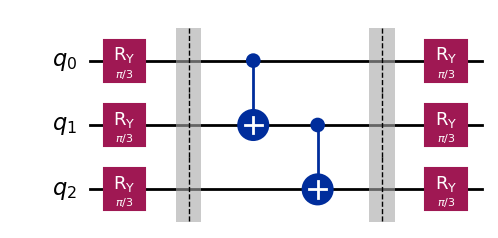

In [198]:
ansatz = RealAmplitudes(3, entanglement='linear', reps=1, insert_barriers=True)
# ansatz.cx(0, 2)
# ansatz.cx(0, 1)
# ansatz.ry(np.pi/3, 0)
# ansatz.ry(np.pi/3, 1)
initial_point = np.ones(ansatz.num_parameters) * np.pi/3
internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
internal_anstaz.decompose().draw('mpl', style='iqx')

In [199]:
print(Expectation_Exact("X", 0, 0, circ=internal_anstaz))

0.8080127018922192


In [220]:
qc = QuantumCircuit(3)
qc.ry(np.pi/6 ,0)
qc.ry(np.pi/3 ,1)
qc.ry(np.pi/3 ,2)
qc.cx(0,2)
qc.cx(0,1)
qc.x(1)
qc.draw('mpl', style='iqx')
print(Expectation_Exact("YY", 0, 2, qc))
print(Expectation_Exact("ZZ", 0, 2, qc))
print(Expectation_Exact("X", 2, 2, qc))

-0.21650635094610948
0.5
0.8660254037844384


# Step 2: Ansatz construction

In [ ]:
# Prepare general State Circuit (n Qubit)-Multicontrol qubit
def PrepareState_Gen(parameter,q = 2):
    # Multi control U3 gate
    def MCUGate(p1,p2,ctrlqubit):
        ctrl = QuantumCircuit(1, name='U3')
        # U3 decompose
        ctrl.rz(p2,0)
        ctrl.rx(-np.pi/2,0)
        ctrl.rz(p1,0)
        ctrl.rx(np.pi/2,0)
        ctrl.rz(-p2,0)
        # U3 decompose
        ctrl = ctrl.to_gate().control(ctrlqubit)
        return ctrl
    # State's bit string converter
    def Bitstring(inter,leng):
        result = []
        while inter >= 2:
            d = inter % 2
            inter = inter//2
            result.append(d)
        result.append(inter)
        for i in range(leng-len(result)):
            result.append(0)
        return result

    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    qc.u(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    # Apply multi-control qubit gate
    for i in range(q-1):
        listctrl = [ i+n+1 for n in range(q-i-1)]
        listctrl.append(i)
        for j in range(2**(q-i-1)):
            bitstring = Bitstring(j,q-i-1)
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1)
            qc.append(MCUGate(parameter[theta],parameter[theta+1],q-i-1),listctrl) 
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1) 
            theta +=2
        qc.barrier(range(q))
    return qc

# Step 3: Optimization

Finite Difference

In [223]:
def FiniteDiff_exact(q,h,qc,parameters, epsilon = 1e-3 ,l_rate=0.2, ite = 100):
    """
    ite: number of interation
    
    """
    Deriva = [[0] for i in range(qc[0].num_parameters)]
    Upd_para = [[0] for i in range(qc[0].num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        vqe.append(vqe_exact(qc[0], parameters,q,h))
        print(parameters)
        print(vqe_exact(qc[0], parameters,q,h))
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_diff = [0 for i in range(len(parameters))]
            finite_diff[i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(vqe_exact(qc[0], [fix_parameters[i] + finite_diff[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0],[fix_parameters[i] - finite_diff[i] for i in range(len(fix_parameters))],q,h)))
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        # vqe.append(vqe_exact(qc[0], parameters,q,h))
    return vqe_exact(qc[0], parameters,q,h), Deriva, Upd_para, vqe

[0. 0. 0. 0. 0. 0.]
1.9999999999999993
[ 0.          0.         -0.19999997 -0.19999997 -0.19999997 -0.19999997]
1.0764747607439835
[ 0.00156827  0.03878447 -0.4605433  -0.43495507 -0.47155238 -0.4605433 ]
-0.339584899866358
[ 0.01109303  0.1121604  -0.73248698 -0.6907556  -0.7851003  -0.72007599]
-1.7461644841311994
[ 0.04924112  0.16265324 -0.91825688 -0.92868699 -1.03883007 -0.87108727]
-2.4716096585321488
[ 0.11499221  0.14404961 -0.99923708 -1.11606284 -1.18105615 -0.90690944]
-2.7575385458402932
[ 0.18318719  0.079393   -1.02934964 -1.2617546  -1.25702687 -0.89469048]
-2.9269175407360226
[ 2.39085701e-01 -1.07247884e-03 -1.04210002e+00 -1.37985968e+00
 -1.30560644e+00 -8.72043125e-01]
-3.049880414124212
[ 0.27939904 -0.08154015 -1.04990471 -1.47581213 -1.34255453 -0.85153306]
-3.1375691515811557
[ 0.30578495 -0.15527223 -1.05660497 -1.55206141 -1.37343297 -0.83602129]
-3.197508543700851
[ 0.32152434 -0.22009383 -1.06297885 -1.61120421 -1.4003997  -0.82515721]
-3.2376046163776175


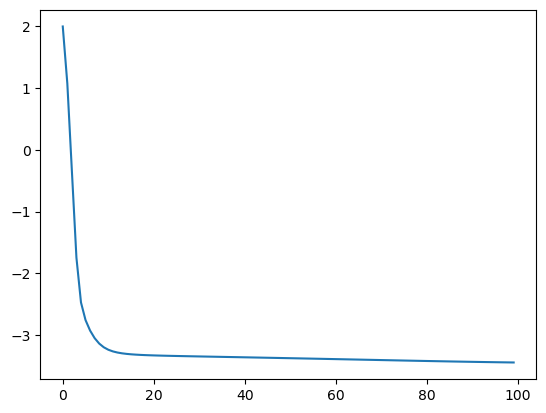

In [224]:
# Test finite difference
q = 3
h = 1
epsilon = 1e-3
l_rate = 0.2
ansatz  = [[]]
ansatz[0] = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = np.zeros(ansatz[0].num_parameters)
# qc.decompose().draw('mpl')
result = FiniteDiff_exact(q,h,ansatz,parameters, epsilon = epsilon ,l_rate = l_rate, ite = 100)
import matplotlib.pyplot as plt
plt.plot(result[3])

Parameter-Shift Rule

In [225]:
def PSR_exact(q,h,qc,parameters, l_rate=0.2, ite = 100):
    Deriva = [[0] for i in range(qc[0].num_parameters)]
    Upd_para = [[0] for i in range(qc[0].num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]

        fix_parameters = [0 for i in range(len(parameters))]

        print(parameters)
        print(vqe_exact(qc[0], parameters,q,h))
        vqe.append(vqe_exact(qc[0], parameters,q,h))

        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
            
        for i in range(len(parameters)):
            PSR_parameter = [0 for i in range(len(parameters))]
            PSR_parameter[i] = np.pi/2

            if i % 2 == 0:
                Dvqe[i] = (1/2*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0],[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            else:
                # For general ansatz
                if qc[1] == 'gen':
                    Dvqe[i] = (1/sqrt(2)*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0], [fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
                # For Pauli rotation gate ansatz
                else:
                    Dvqe[i] = (1/2*(vqe_exact(qc[0], [fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(qc[0], [fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
            
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        # vqe.append(vqe_exact(qc[0], parameters,q,h))
    return vqe_exact(qc[0], parameters,q,h), Deriva, Upd_para, vqe

[0. 0. 0. 0. 0. 0.]
1.9999999999999993


[ 0.   0.  -0.2 -0.2 -0.2 -0.2]
1.0764745894781305
[-0.0078939   0.03878448 -0.46054338 -0.43495515 -0.47155246 -0.46054338]
-0.340885820670074
[-0.04250822  0.11180787 -0.73237911 -0.69134963 -0.78563361 -0.72007196]
-1.7606485279861475
[-0.11011871  0.15954395 -0.91660346 -0.93318355 -1.04237523 -0.87095178]
-2.5154511947469502
[-0.19302107  0.13572199 -0.99078051 -1.12764672 -1.1896361  -0.90649667]
-2.8282654115850048
[-0.27193316  0.06515068 -1.00681075 -1.27896991 -1.27102308 -0.89506138]
-3.0167640192511564
[-0.336552   -0.02094067 -0.99918949 -1.3987369  -1.32565704 -0.87586348]
-3.151666515735454
[-0.38381646 -0.10624423 -0.98223086 -1.4918708  -1.36968656 -0.86223846]
-3.245271144376951
[-0.41514308 -0.18384098 -0.96161921 -1.56127263 -1.40857991 -0.85685335]
-3.307647113297463
[-0.434137   -0.25156735 -0.93963968 -1.61051253 -1.44413601 -0.85857508]
-3.3491117920958775
[-0.44479886 -0.30945545 -0.91725051 -1.64369537 -1.47701881 -0.86527902]
-3.377533364061226
[-0.45048322 -

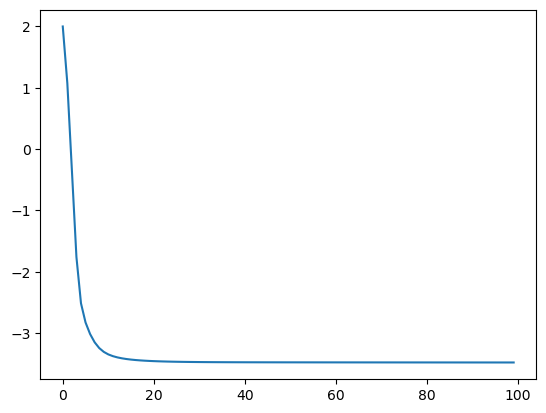

In [226]:
q = 3
h = 1
l_rate = 0.2
ansatz = [[],[]]
ansatz[0] = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = np.zeros(ansatz[0].num_parameters)
# qc.decompose().draw('mpl')
result = PSR_exact(q,h,ansatz,parameters ,l_rate = l_rate, ite = 100)
import matplotlib.pyplot as plt
plt.plot(result[3])

In [222]:
from qiskit import RealAmplitudes
qc = RealAmplitudes(3,1)
qc.draw('mpl', style='iqx')

ImportError: cannot import name 'RealAmplitudes' from 'qiskit' (d:\Users\DELL\anaconda3\lib\site-packages\qiskit\__init__.py)

Quantum Natural Gradient

In [216]:
q = 3
h = 1
l_rate = 0.2
numberofiteration = 100

RealAmp = {'qubit': q , 'entanglement': 'linear','reps':1}
real = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=RealAmp['reps'])
num_para = real.num_parameters

itera0 = []
value0 = []

# Create sub-circuit
qc = [0 for i in range(int(num_para/q))]
for k in range(int(num_para/q)):
        qc[k] = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=k,skip_final_rotation_layer=True)


parameters = [0.5 for i in range(num_para)]

for l in range(numberofiteration):
    print(parameters)
    print(vqe_exact(real,parameters,q,h))
    value0.append(vqe_exact(real,parameters,q,h))
    # itera0.append(l)
    Dvqe = [0 for i in range(len(parameters))]
    fix_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        fix_parameters[i] = parameters[i]

    # Metric tensor
    g = np.zeros([num_para,num_para])
    sqc = [0 for i in range(int(num_para/q))]
    for m in range(num_para):
        k = m/q
        if k.is_integer():
            k = int(k)
            sqc[k] =  qc[k].assign_parameters(parameters[:q*k])
            for i in range(q):
                for j in range(q):
                    if j == i: 
                        g[i+q*k,j+q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                    else:
                        g[i+q*k,j+q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])

    # Paramter-shift rules
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[m] = np.pi/2
        Dvqe[m] = (1/2*(vqe_exact(real,[fix_parameters[i] + PSR_parameter[i] for i in range(len(fix_parameters))],q,h)-vqe_exact(real,[fix_parameters[i] - PSR_parameter[i] for i in range(len(fix_parameters))],q,h)))
    
    # Pseudo-inverse
    g = g/4
    print(g)
    g = linalg.pinv(g)
    # Update papramter
    for i in range(num_para):
        for j in range(num_para):
            parameters[i]-=l_rate*g[i,j]*Dvqe[j]
    # print(parameters)
    # print(vqe_exact(real,parameters,q,h))
    

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
3.212706723160034
[[ 2.50000000e-01  1.11022302e-16  1.11022302e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.11022302e-16  2.50000000e-01  1.11022302e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.11022302e-16  1.11022302e-16  2.50000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.50000000e-01
  -5.04278350e-02  1.11022302e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.04278350e-02
   2.50000000e-01 -1.05183873e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.11022302e-16
  -1.05183873e-01  2.50000000e-01]]
[0.5091300828843691, 0.4026154595106365, 0.2998982929676725, 0.1312278765646469, 0.39223866875846264, 0.5255392642515333]
2.8987956133706168
[[ 2.50000000e-01  1.11022302e-16  1.11022302e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.11022302e-16  2.50000000e-01  1.11022302e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 

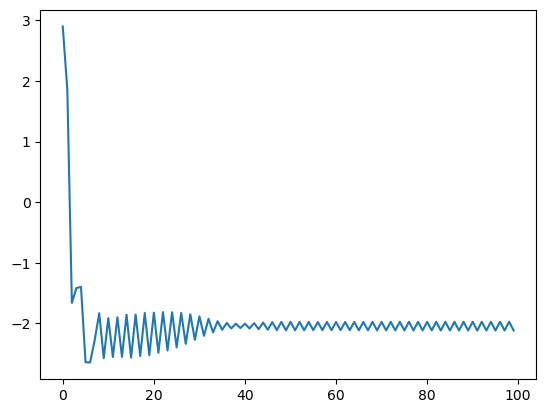

In [215]:
plt.plot(value0)

# SPSA

In [232]:
def SPSA_exact(q,h,qc,parameters, epsilon = 0.01, l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    for j in range(ite):
        print(parameters)
        print(vqe_exact(qc, parameters,q,h))
        Dvqe = [0 for i in range(len(parameters))]
        # Perturbation vector
        # per_vec = [np.random.choice([1,-1])*epsilon for i in range(len(parameters))]
        per_vec = np.array([1 for _ in range(ansatz.num_parameters)])
        # SPSA gradient
        spsa_diff = vqe_exact(qc, np.add(parameters,per_vec),q,h)-vqe_exact(qc,np.subtract(parameters,per_vec),q,h)
        for i in range(len(parameters)):

            Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_exact(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

[0. 0. 0. 0. 0. 0.]
1.9999999999999993
[-0.01709556 -0.01709556 -0.01709556 -0.01709556 -0.01709556 -0.01709556]
1.9310543139658087
[-0.03419092 -0.03419092 -0.03419092 -0.03419092 -0.03419092 -0.03419092]
1.8610686619924297
[-0.05128043 -0.05128043 -0.05128043 -0.05128043 -0.05128043 -0.05128043]
1.7901998899160998
[-0.06835914 -0.06835914 -0.06835914 -0.06835914 -0.06835914 -0.06835914]
1.7186076464121252
[-0.08542277 -0.08542277 -0.08542277 -0.08542277 -0.08542277 -0.08542277]
1.6464533682476914
[-0.10246766 -0.10246766 -0.10246766 -0.10246766 -0.10246766 -0.10246766]
1.57389934064614
[-0.11949075 -0.11949075 -0.11949075 -0.11949075 -0.11949075 -0.11949075]
1.5011078368235884
[-0.13648946 -0.13648946 -0.13648946 -0.13648946 -0.13648946 -0.13648946]
1.4282403372945716
[-0.15346169 -0.15346169 -0.15346169 -0.15346169 -0.15346169 -0.15346169]
1.3554568265530222
[-0.17040574 -0.17040574 -0.17040574 -0.17040574 -0.17040574 -0.17040574]
1.2829151622722903
[-0.18732025 -0.18732025 -0.18732

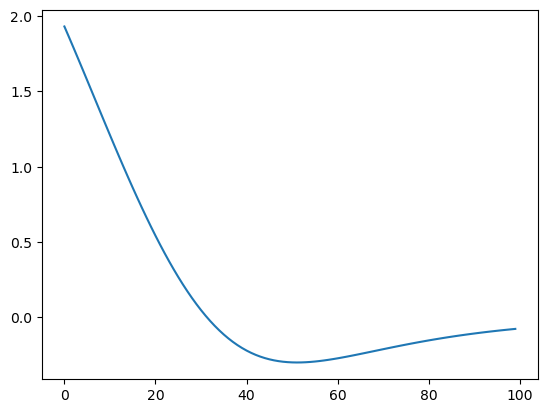

In [234]:
q = 3
h = 1
l_rate = 0.01
ansatz = RealAmplitudes(q, entanglement='linear', reps=1)
parameters = np.zeros(ansatz.num_parameters)
# qc.decompose().draw('mpl')
result = SPSA_exact(q,h,ansatz,parameters ,l_rate = l_rate, ite = 100)
import matplotlib.pyplot as plt
plt.plot(result[3])

# QN-SPSA

In [ ]:
def QN_SPSA(qc,parameter,gk_1,Nth_iter,beta = 0.001 ,eps = 0.01):
    q = qc.num_qubits
    num_parameters = qc.num_parameters
    # Metric tensor
    g = np.zeros([num_parameters,num_parameters])
    # Perturbation vector
    # per_vec1 = [np.random.choice([1,-1])*eps for i in range(num_parameters)]
    # per_vec2 = [np.random.choice([1,-1])*eps for i in range(num_parameters)]
    per_vec1 = [1*eps for i in range(num_parameters)]
    per_vec2 = [1*eps for i in range(num_parameters)]
    # PQC
    qc1 = qc.assign_parameters(np.add(np.add(parameter,per_vec1),per_vec2))
    qc2 = qc.assign_parameters(np.add(parameter,per_vec1))
    qc3 = qc.assign_parameters(np.add(np.add(parameter,[-i for i in per_vec1]),per_vec2))
    qc4 = qc.assign_parameters(np.add(parameter,[-i for i in per_vec1]))
    qc =  qc.assign_parameters(parameter).inverse()
    # Construct expecation value
    qc1.append(qc,[_ for _ in range(q)])
    qc2.append(qc,[_ for _ in range(q)])
    qc3.append(qc,[_ for _ in range(q)])
    qc4.append(qc,[_ for _ in range(q)])
    # Execute the circuits
    backend = Aer.get_backend('statevector_simulator')
    job = execute([qc1,qc2,qc3,qc4], backend) 
    result = job.result().get_counts()
    # Get the |000..0> state index
    index = ''
    for i in range(q):
        index += '0'
    # Get the wanted results from running backend
    fun = [0]*4
    for i in range(4):
        for ind in result[i]:
            if ind == index:
                fun[i] = result[i][index]
    # Calculating the shifting value
    F = [fun[0],-fun[1],-fun[2],fun[3]]
    F = sum(F)
    print(f'F: {F}')
    # QN_SPSA matrix
    for i in range(num_parameters):
        for j in range(num_parameters):
            g[i][j]=-1/2*F/(2*eps**4)*(per_vec1[i]*per_vec2[j]+per_vec1[j]*per_vec2[i])/2
    print(f'g: {g}')
    # The smoothing of the QN_SPSA matrix
    g = Nth_iter/(Nth_iter+1)*gk_1+1/(Nth_iter+1)*g
    print(f'g_m: {g}')
    # Regularization to ensure invertibility (positive semi-definite)
    print(f'B {g.conjugate().transpose().dot(g)}')
    B = g.conjugate().transpose().dot(g)
    A = sqrtm(B)
    print(f'A: {A}')
    g = A+beta*np.identity(num_parameters)

    return g

In [ ]:
def SPSA_QN_SPSA(q,h,qc,parameters, epsilon = 0.01 ,l_rate=0.01, ite = 100):
    num_parameters = qc.num_parameters
    Deriva = [[0] for i in range(num_parameters)]
    Upd_para = [[0] for i in range(num_parameters)]
    vqe = []
    # Instantiate the preceding running result
    g1 = np.zeros([num_parameters,num_parameters])
    for j in range(ite):
        Dvqe = [0 for i in range(num_parameters)]
        # Perturbation vector
        per_vec = [np.random.choice([1,-1])*epsilon for i in range(num_parameters)]
        # SPSA gradient
        spsa_diff = vqe_backend(qc, np.add(parameters,per_vec),q,h)-vqe_backend(qc,np.subtract(parameters,per_vec),q,h)
        for i in range(num_parameters):

            Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
        # Get the QN_SPSA
        g = QN_SPSA(qc,parameters,g1,Nth_iter=j)
        state = True
        while state:
            try:
                # Pseudo-inverse
                g_1 = linalg.pinv(g)
                state = False
            except:
                g = QN_SPSA(qc,parameters,g1,Nth_iter=i)
        # save for the next running
        g1 = g
        # Update papramter
        for i in range(num_parameters):
            for j in range(num_parameters):
                parameters[i]-=l_rate*g_1[i,j]*Dvqe[j]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

# Step 4: Variational Quantum Eigensolver

In [77]:
def vqe_exact(qc, parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("ZZ",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + (Zterm + h*Xterm)

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton 

In [94]:
# ansatz[0].decompose().draw('mpl', style='iqx')
qc = ansatz[0].assign_parameters(parameter)

NameError: name 'parameter' is not defined

In [127]:
# initial_point = np.array([ 0.64600354, -0.85128018, -1.04730893, -1.07769523, -2.47758958, -0.30493529])
# initial_point = np.array([-0.49395506, -0.53044856, -0.43088709, -1.50952584, -1.76176268, -1.1278869 ])
initial_point = np.ones(ansatz[0].num_parameters) * np.pi/3
print(vqe_exact(ansatz[0], initial_point, 3, 1))

AttributeError: 'CircuitInstruction' object has no attribute 'num_parameters'

In [197]:
# ansatz[0].decompose().draw('mpl', style='iqx')
qc1 = ansatz[0].assign_parameters(initial_point)
qc1.decompose().draw('mpl', style='iqx')

AttributeError: 'CircuitInstruction' object has no attribute 'assign_parameters'

In [192]:
print(Expectation_Exact("Z", 0, 2, qc1))

-0.046084439370113306


In [ ]:
def vqe_exact1(qc,parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("ZZ",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        # file.write(f'Parameter: {parameter} \n ')
        # file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [ ]:
def vqe_backend(qc,parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_backend("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_backend("ZZ",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [ ]:
def vqe_backend_opt(parameter,qc, q,h,meas_map = None,file=None,shots=20000,realbackend = provider.get_backend('ibmq_qasm_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = TwoLocal(q, ['ry','rz'], 'cz', 'linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    
    def Qcir(gate=None,p=None,q = q,qc = qc):
        if gate == 'ZZ':
            cir = QuantumCircuit(q,2)
            cir.append(qc,[i for i in range(q)])
            cir.measure([p,p+1], [0,1])
        elif gate == 'X':
            cir = QuantumCircuit(q,1)
            cir.append(qc,[i for i in range(q)])
            cir.h(p)
            cir.measure(p,0)
        cir = transpile(cir, backend=backend,optimization_level=3)
        return cir

    def Check(result,index,shots = shots):
        if index not in result:
            result[index]=0
        return result[index]/shots
        
    Z_cir = [0 for i in range(q-1)]
    X_cir = [0 for i in range(q)]
    for i in range(q):
        X_cir[i] = Qcir('X',i)
        if i < (q-1):
            Z_cir[i] = Qcir('ZZ',i)
    Hamil_cir = []
    Hamil_cir = Z_cir+X_cir
    
    Assem = assemble(Hamil_cir, backend,meas_map=meas_map,shots=shots)
    job = backend.run(Assem)    
    result = job.result().get_counts()

    Ising_Hamilton = 0
    for i in range(q):
        Xterm = 2*Check(result[q+i-1],'0')-1
        if i < (q-1):
            Zterm = 4*(Check(result[i],'00'))-1-(2*(Check(result[i],'00')+Check(result[i],'01'))-1)-(2*(Check(result[i],'00')+Check(result[i],'10'))-1)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    
    # File write
    if file != None:
        file.write(f'\n Job ID: {job.job_id()} \n ')
        file.write(f'Parameter: {parameter} \n ')
        file.write(f'Result: {result} \n ')
        file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [ ]:
def vqe_exact_opt(parameter,q,h,file=None,realbackend = Aer.get_backend('statevector_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # backend = Aer.get_backend('statevector_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend

    def Res(result,p,gate):
        value = 0
        if gate == 'X':
            for index in result:
                if index[::-1][p:(p+1)] == '0':
                    value += result[index]
        elif gate == 'ZZ':
            for index in result:
                if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                    value += result[index]
        return (2*value -1)
        
        
    Z_cir =  QuantumCircuit(q)
    Z_cir.append(qc,[i for i in range(q)])
    X_cir =  QuantumCircuit(q)
    X_cir.append(qc,[i for i in range(q)])
    X_cir.h([i for i in range(q)])
    Hamil_cir = [Z_cir,X_cir]
    
    job = execute(Hamil_cir, backend) 
    result = job.result().get_counts()

    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Res(result[1],i,'X')
        if i < (q-1):
            Zterm = Res(result[0],i,'ZZ')
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    
    # File write
    if file != None:
        file.write(f'\n Job ID: {job.job_id()} \n ')
        file.write(f'Parameter: {parameter} \n ')
        file.write(f'Result: {result} \n ')
        file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

# Step 5: The Ising model

In [23]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

In [27]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver

exact_solver = NumPyEigensolver(k=100)
hamiltonian = Ising_Hamilton(2, 1)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(hamiltonian)
print(exact_result.eigenvalues.real)

1.0 * ZZ
+ 1.0 * XI
+ 1.0 * IX
[-2.23606798 -1.          1.          2.23606798]


# Step 6: Test VQE

In [ ]:
from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

start_time = time.time()

num_qubits =  2 # (N_p = num_qubit-1)
reps = 1
J = -1
h = -1



intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


# ansatz = Customize_EfficientSU2(num_qubits, 1)

hamiltonian = Ising_hamiltonian(num_qubits, J, h)
ansatz = Customize_RealAmplidues(num_qubits, reps)
# ansatz = Customize_EfficientSU2(num_qubits, reps)

interation = 100

initial_point = np.zeros(ansatz.num_parameters)
# initial_point = np.random.rand(num_qubits)+1.2
# initial_point = np.array([ 2.86022673,  1.30314025,  2.05637214,  1.29459261,  0.19461221,  0.30451271,
#   3.34798259, -0.88489075, -1.56792844, -1.1410738,   0.0519218,  -0.60728212,
#  -0.76819862,  0.61490753, -0.42952656])

# initial_point = np.array([1.5, 5.5])


eta = 0.1
shots = 20000

from qiskit import Aer

backend = Aer.get_backend('statevector_simulator')
# backend = Aer.get_backend('qasm_simulator')

# energy = Customize_imaginary_time_evolution(hamiltonian, interation, ansatz, eta, initial_point, shots, backend, callback=None)

# energy = Customize_Nelder_Mead(hamiltonian, interation, ansatz, initial_point, shots, backend, callback=None)

# energy = Customize_QN_SPSA(hamiltonian, interation, ansatz, initial_point, shots, backend, callback)
# energy = Customize_SPSA(hamiltonian, interation, ansatz, initial_point, shots, backend, callback=None)
optimize = Customize_Quantum_Natural_Graident_Descent

energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, optimize, interation, ansatz, eta, initial_point, shots, backend, callback=callback)
# print(VQE_runtime)


# file_name = f'{str(optimize.__name__)} - LR {eta} - shots {shots} - interation {interation} - RealAmplitudes({num_qubits},{reps}) - J{J}h{h}'

# file = open(f'D:/Book store/Learning document/QC/Master_Duy_project/VQE_result/{file_name}.txt', 'w')

# file.write('Parameters: \n')
# file.write(str(intermediate_info['parameters']))

# for i in range(3):
#     file.write('\n')

# file.write('Energy: \n')
# file.write(str(intermediate_info['energy']))

# file.close()


# DURING REPAIR

Customize SPSA

In [ ]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

def Customize_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    
    internal_initial_point = initial_point.copy()

    energy = []

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)


        # Optimization part
        grad = np.zeros(ansatz.num_parameters)
        ak = a/(1+k+A)**alpha
        ck = c/(1+k)**gamma
        
        print(f'ak_{k}: {ak}')
        print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = ak*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            grad = np.add(grad, grad_func*random)
        print(f'grad: {grad}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy


Customize QN-SPSA

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer, execute

def SwapTest(circ1, circ2, shots, backend):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    result = execute(circ, backend, shots=shots).result()

    counts = result.get_counts()

    overlap_value = 0

    if '1' in counts:
        # Key exists, do something with data['value']
        overlap_value = counts['1']
    else:
        # Key doesn't exist, return to default value (0 in this case)
        overlap_value = 0
    
    overlap_value = 1 - 2*overlap_value/shots

    

    
    return overlap_value, circ

def Customize_QN_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    # c = 0.08
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    # delTheta = 0.001
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    # a = 0.001

    #  regularization coefficient
    beta = 0.05
    
    internal_initial_point = initial_point.copy()

    energy = []

    regularized_fubini_matrix_previous = np.zeros((ansatz.num_parameters, ansatz.num_parameters))

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)

        grad = np.zeros(ansatz.num_parameters)
        # SPSA part
        gradSPSA = np.zeros(ansatz.num_parameters)
        ak = a/(1+k+A)**alpha
        # ak = 0.001
        ck = c/(1+k)**gamma
        # ck = 0.05
        
        print(f'ak_{k}: {ak}')
        print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            gradSPSA = np.add(gradSPSA, grad_func*random)
        
        print(f'gradSPSA {gradSPSA}')

        
        # Natural Gradient Part
        random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        initial_plus1_plus2 = np.add(initial_point, np.add(ck*random1, ck*random2))
        initial_plus1 = np.add(initial_point, ck*random1)
        initial_minus1_plus2 = np.subtract(initial_point, np.subtract(ck*random1, ck*random2))
        initial_minus1 = np.subtract(initial_point, ck*random1)

        ansatz_initial = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1_plus2 = ansatz.bind_parameters({theta: initial_plus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1 = ansatz.bind_parameters({theta: initial_plus1[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1_plus2 = ansatz.bind_parameters({theta: initial_minus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1 =  ansatz.bind_parameters({theta: initial_minus1[k] for k, theta in enumerate(ansatz.parameters)})  

        deltaF = SwapTest(ansatz_initial, ansatz_plus1_plus2, shots, backend)[0] - SwapTest(ansatz_initial, ansatz_plus1, shots, backend)[0] -SwapTest(ansatz_initial, ansatz_minus1_plus2, shots, backend)[0] + SwapTest(ansatz_initial, ansatz_minus1, shots, backend)[0]

        # Fubini_matrix
        fubini_matrix = -1/2*(deltaF/(2*ck**2))*(np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2
        
        # Data of previous regularized study metric
        exponentially_smoothed_fubini = k/(k+1)*regularized_fubini_matrix_previous + 1/(k+1)*fubini_matrix.copy()

    
        regularized_fubini_matrix = np.add(np.power(exponentially_smoothed_fubini*exponentially_smoothed_fubini, 1/2), beta*np.identity(ansatz.num_parameters))

        regularized_fubini_matrix_previous = regularized_fubini_matrix

        # print(f'regularized_fubini_matrix---{regularized_fubini_matrix}')

        grad = ak*np.linalg.pinv(regularized_fubini_matrix).dot(gradSPSA)

        print(f'grad: {grad/ak}')
        print(f'parameter {internal_initial_point}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy